# Demo of LogRegModel Class and it's Methods

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries-and-data" data-toc-modified-id="Load-libraries-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries and data</a></span><ul class="toc-item"><li><span><a href="#Check-dataframe-structure" data-toc-modified-id="Check-dataframe-structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check dataframe structure</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepare data</a></span></li></ul></li><li><span><a href="#Initialize-Your-Model" data-toc-modified-id="Initialize-Your-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialize Your Model</a></span></li><li><span><a href="#Use-the-function-go_quickDirty-for-one-step-logistic-regression-modelling" data-toc-modified-id="Use-the-function-go_quickDirty-for-one-step-logistic-regression-modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Use the function <code>go_quickDirty</code> for one-step logistic regression modelling</a></span><ul class="toc-item"><li><span><a href="#Background-information-on-evaluation-scores" data-toc-modified-id="Background-information-on-evaluation-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Background information on evaluation scores</a></span></li></ul></li><li><span><a href="#Evaluate-the-model" data-toc-modified-id="Evaluate-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate the model</a></span></li></ul></div>

## Load libraries and data

In [1]:
import numpy as np
import pandas as pd

import EDA_functions, cleaning_functions
from logRegModel_class import LogRegModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import log_loss, f1_score, confusion_matrix, \
    classification_report
from sklearn.utils import resample  # for error calculation of feature weights

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# display all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
titanic = pd.read_csv('../data/train_titanic.csv')

### Check dataframe structure
(For real projects some of the steps below should only be performed after separating the test set)

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
titanic.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
614,615,0,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.05,NaN,S
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.00,C128,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S


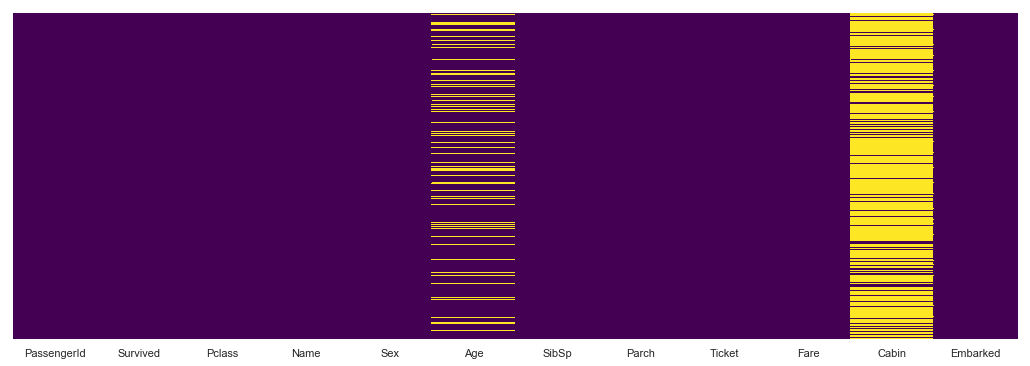

In [5]:
cleaning_functions.plot_NaN(titanic)

In [6]:
cleaning_functions.list_NaN(titanic)

,total,percent,dtype
Cabin,687,77.1,object
Age,177,19.9,float64
Embarked,2,0.2,object


In [7]:
for col in ['SibSp', 'Parch']:
    print(titanic[col].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


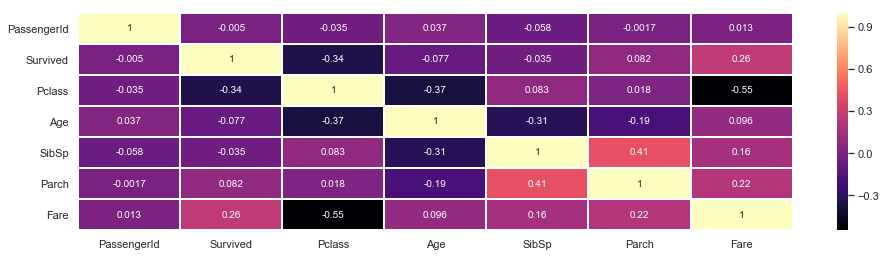

In [8]:
EDA_functions.plot_corr_map_num_all(titanic, figsize=(16,4))

**Need for cleaning:**
- cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
- cols_to_cat = ['Sex', 'Parch', 'SibSp', 'Embarked']
    

### Prepare data

In [9]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
cols_to_cat = ['Sex', 'Parch', 'SibSp', 'Embarked']

titanic = cleaning_functions.change_dtypes(titanic, cols_to_category=cols_to_cat)
titanic = cleaning_functions.delete_columns(titanic, cols_to_delete=cols_to_drop)

PassengerId successfully deleted
Name successfully deleted
Ticket successfully deleted
Cabin successfully deleted


In [10]:
# Check results
display(titanic.head())
print(titanic.info())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null category
Age         714 non-null float64
SibSp       891 non-null category
Parch       891 non-null category
Fare        891 non-null float64
Embarked    889 non-null category
dtypes: category(4), float64(2), int64(2)
memory usage: 32.3 KB
None


## Initialize Your Model

First step is to initialize a (or a couple of different) linear scikit-learn model object with it's correspoding parameters. 

In [11]:
# define a scikit-learn model object you want to work with
model = LogisticRegression()
# create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
logReg_simple = LogRegModel(titanic, 'Survived', model)

In [12]:
# you can output the model with help of the instance variable name
logReg_simple

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Use the function `go_quickDirty` for one-step logistic regression modelling

`go_quickDirty` is a method of the LogRegModel class for preprocessing data, fitting and testing a logistic regression model _in one step_. You can pass (almost) any unprepared data. (It is called quick & dirty because the preprocessing is quite unsophisticated: NA values will be  handled in a simple way, categorical variables dummied. But there is no outlier treatment or scaling.)

Details on preprocessing:
- All columns with dtype object and category will be one-hot-encoded. (Make sure they all have categorical character.)
- All NaN in numerical cols will be imputed with mean, all NaN in non-numerical columns will be dummied (for mixing into the zero category, change the 'dummy_na' parameter)

In [13]:
# perform linear regression modelling on instance
logReg_simple.go_quickDirty()

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
# after modelling you can ouptut the RMSE and the r2-Score with help of the instance variable name
logReg_simple

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

F1-score on test data 0.75, logloss 6.57.

### Background information on evaluation scores
- WIP
- ...

## Evaluate the model

[learning_curve] Training set sizes: [  4  30  56  82 108 134 160 186 212 238 264 290 316 342 368 394 420 446
 472 498]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


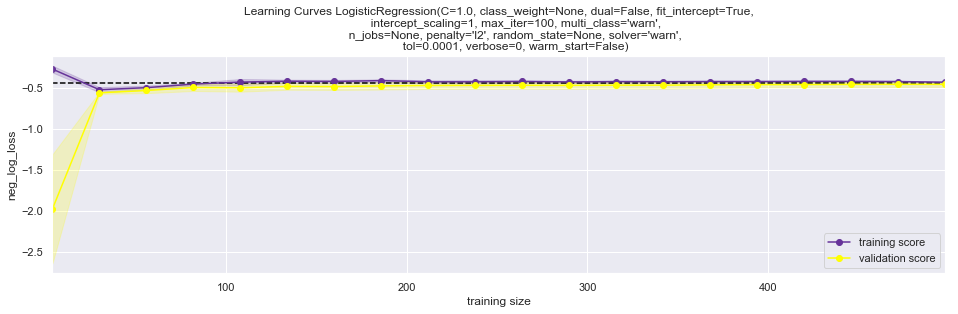

In [15]:
# plot learning curves using 5-fold cross validation
logReg_simple.plot_learning_curves()

In [16]:
logReg_simple.print_classification_report()

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       159
           1       0.80      0.71      0.75       109

   micro avg       0.81      0.81      0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



In [17]:
# plot feature weights (error estimation by bootstrapping)
logReg_simple.print_coef_weights(n_bootstrap=5)

ValueError: Length of values does not match length of index

**Interpretation:** The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty.  Because of this penalty, and because all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the target variable. The larger the coefficient, the larger the expected impact. 

***